In this tutorial, we show how to sample parameters using different distributions.

The final outcome is a pandas dataframe where columns are different distributions and rows are different parameter sets. 

This can be extended for any parameters of your model, meaning if your model has x parameters and you want n samples, you will create a dataframe with n rows and x columns.

## Package Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Functions required

**Distribution functions**

Given a the values that define the distribution and size, a dataset of length size with that distribution is generated. 

In [2]:
def parameterGaussian( mean, noisetosignal, size):
    stdev = noisetosignal * mean
    gaussianDistribution = np.random.normal(mean, stdev, size)
    return gaussianDistribution

def parameterLogNormal( mean, noisetosignal, size):
    sigma = noisetosignal * mean
    normal_std = np.sqrt(np.log(1 + (sigma/mean)**2))
    normal_mean = np.log(mean) - normal_std**2 / 2
    lognormalDistribution = np.random.lognormal(normal_mean, normal_std, size)
    return lognormalDistribution

def parameterLogUniform( min, max, size):
    loguniform = lambda size:  (10) ** (np.random.uniform(-3, 3, size))
    loguniformDistribution = loguniform(size)
    croppedLoguniformDistribution = np.array([x for x in loguniformDistribution if min <= x <= max])
    return croppedLoguniformDistribution

def parameterFixed( value, size):
    fixedDistribution = np.full((size), value)
    return fixedDistribution


def call_parameter_distribution(parameterDict,size):
    if parameterDict['distribution']=='gaussian':
        dist = parameterGaussian(parameterDict['mean'], parameterDict['noisetosignal'],size)
    if parameterDict['distribution']=='lognormal':
        dist = parameterLogNormal(parameterDict['mean'], parameterDict['sigma'],size)
    if parameterDict['distribution']=='loguniform':
        dist =  parameterLogUniform(parameterDict['min'], parameterDict['max'],size)
    if parameterDict['distribution']=='fixed':
        dist =  parameterFixed(parameterDict['value'],size)
    return dist


**Latin Hypercube Sampling function**

Given a dataset with a certain distribution (data) and a number of samples (nsample), generate a lhs distributed dataset of length nsamples. 

In [3]:
#This function takes the list of dictionaries with all the different distributions desired (parameterDictList) and 
#generates a stackedDistribution which will serve as an input to the lhs function. 
#This stacked distribution has a column per distribution and the same number of rows for all
def preLhs(parameterDictList):
    parameterDistributionList = [call_parameter_distribution(parameterDict,100000) for parameterDict in parameterDictList] 
    distributionMinimumLenght = np.amin([len(x) for x in parameterDistributionList])
    croppedParameterDistributionList = [x[:distributionMinimumLenght] for x in parameterDistributionList]
    stackedDistributions = np.column_stack((croppedParameterDistributionList))
    return stackedDistributions


def lhs(data, nsample,seed=1, tqdm_disable=False):
    np.random.seed(seed)
    m, nvar = data.shape
    ran = np.random.uniform(size=(nsample, nvar))
    s = np.zeros((nsample, nvar))
    for j in tqdm(range(0, nvar), disable=tqdm_disable):
        idx = np.random.permutation(nsample) + 1
        P = ((idx - ran[:, j]) / nsample) * 100
        s[:, j] = np.percentile(data[:, j], P)

    if np.any(s<=0):
        print('WARNING: negative values in lhs')
        s[s<0] = 0.001
        
    return s

**PlotDist function**

This function plots all distributions found in lhsDist_df

In [4]:
def plotDistributions(parameterDictList,lhsDist_df):
    nvar = len(parameterDictList)
  
    fig,axs = plt.subplots(nrows=1,ncols=nvar,figsize=(nvar*5,5))
    for count,parameter in enumerate(parameterDictList):
        name = parameter['name']
        lhsDistColumn = lhsDist_df[name]
        sns.histplot(lhsDistColumn, ax=axs[count], bins=100)
        axs[count].set(ylabel ='',yticks=[],yticklabels=[])
        axs[count].set_xlabel(name, fontsize=15)
    plt.show()

## Creation of distributions dataset

Execute code to generate pandas dataframe with distributions

In [5]:
#Number of samples desired
nsamples=10000

#Different distributions to be used 
Gaussian = {'name':'Gaussian','distribution':'gaussian', 'mean':1, 'noisetosignal':0.2}
LogNormal = {'name':'LogNormal','distribution':'lognormal', 'mean':1, 'sigma':0.1}
LogUniform = {'name':'LogUniform','distribution':'loguniform', 'min':1, 'max':100}
Fixed = {'name':'Fixed','distribution':'fixed','value':1}
parameterDictList = [Gaussian, LogNormal,LogUniform,Fixed]

#Distribution sampling with LHS
stackedDistributions = preLhs(parameterDictList)
lhsDist = lhs(stackedDistributions,nsamples)

#Creation of pandas dataframe with resulting dataset
lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterDictList])
lhsDist_df


100%|██████████| 4/4 [00:00<00:00, 126.62it/s]


,Gaussian,LogNormal,LogUniform,Fixed
0,0.605112,1.073550,12.040107,1.0
1,1.052824,1.081506,3.921946,1.0
2,1.035177,0.826801,14.789205,1.0
3,1.157024,1.184601,12.618921,1.0
4,1.340809,1.189156,14.074043,1.0
...,...,...,...,...
9995,0.778121,1.199984,4.488328,1.0
9996,0.868999,0.934618,45.157432,1.0
9997,1.190547,1.232535,47.883255,1.0
9998,1.004212,1.004331,1.357795,1.0


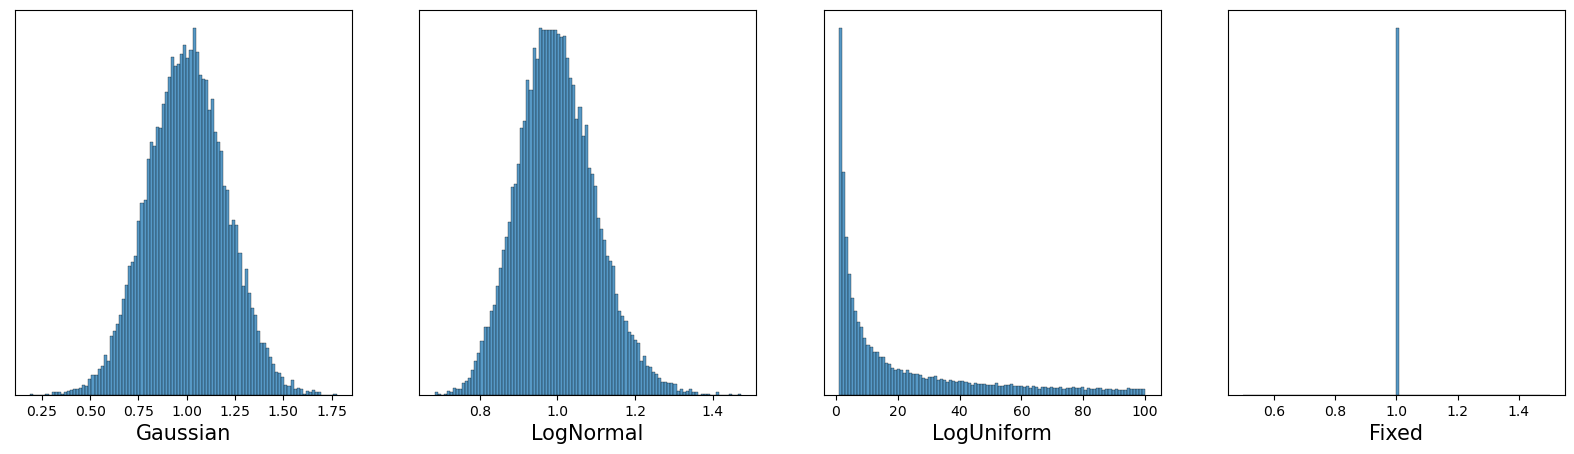

In [7]:
#visualization of distributions
plotDistributions(parameterDictList,lhsDist_df)
